In [1]:
import os

# Data Download

In [2]:
# 결과물을 저장할 폴더를 만듭니다.
path = ['data', 'model', 'result', 'img']
for i in path:
    if not os.path.exists(i):
        os.mkdir(i)

In [ ]:
if not os.path.exist('data/train.csv'):
    !kaggle competitions download -c playground-series-s5e5
    !unzip playground-series-s5e5.zip -d data
    !rm playground-series-s5e5.zip
    !kaggle datasets download ruchikakumbhar/calories-burnt-prediction
    !unzip archive.zip -d data
    !rm archive.zip

In [60]:
import sgml, sgpp, dproc, sgutil

import polars as pl
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

sc = sgutil.SGCache('img', 'result', 'model')

In [62]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit, ShuffleSplit

# Data processing

**Task**

- Train / Test / Org 데이터를 불러오는 루틴 디자인합니다.
- Calories를 Log 변환하고 이 변수를 Calories_Log로 합니다.

In [78]:
p = make_pipeline(
    sgpp.PolarsProcessor(),
    sgpp.PandasConverter(index_col = 'id')
)
df_train = p.fit_transform(['data/train.csv']).assign(
    Calories_Log = lambda x: np.log(x['Calories'] + 1)
)
df_train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Calories_Log
id,,,,,,,,,
0,male,36,189.0,82.0,26.0,101.0,41.000000,150.0,5.017280
1,female,64,163.0,60.0,8.0,85.0,39.700001,34.0,3.555348
2,female,51,161.0,64.0,7.0,84.0,39.799999,29.0,3.401197
3,male,20,192.0,90.0,25.0,105.0,40.700001,140.0,4.948760
4,female,38,166.0,61.0,25.0,102.0,40.599998,146.0,4.990433


- 테스트 데이터를 불러 옵니다.

In [19]:
df_test = p.transform(['data/test.csv'])
df_test.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
id,,,,,,,
750000,male,45,177.0,81.0,7.0,87.0,39.799999
750001,male,26,200.0,97.0,20.0,101.0,40.500000
750002,female,29,188.0,85.0,16.0,102.0,40.400002
750003,female,39,172.0,73.0,20.0,107.0,40.599998
750004,female,30,173.0,67.0,16.0,94.0,40.500000


- 원본 데이터를 불러 옵니다.

In [21]:
p_org = make_pipeline(
    sgpp.PolarsProcessor(),
    sgpp.PandasConverter(index_col = 'User_ID')
)
df_org = p_org.fit_transform(['data/calories.csv']).reset_index(drop=True).pipe(
    lambda x: x.set_index(-(x.index + 1))
)
df_org.head()

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
-1,male,68,190.0,94.0,29.0,105.0,40.799999,231.0
-2,female,20,166.0,60.0,14.0,94.0,40.299999,66.0
-3,male,69,179.0,79.0,5.0,88.0,38.700001,26.0
-4,female,34,179.0,71.0,13.0,100.0,40.500000,71.0
-5,female,27,154.0,58.0,10.0,81.0,39.799999,35.0


In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   Sex           750000 non-null  category
 1   Age           750000 non-null  int8    
 2   Height        750000 non-null  float32 
 3   Weight        750000 non-null  float32 
 4   Duration      750000 non-null  float32 
 5   Heart_Rate    750000 non-null  float32 
 6   Body_Temp     750000 non-null  float32 
 7   Calories      750000 non-null  float32 
 8   Calories_Log  750000 non-null  float32 
dtypes: category(1), float32(7), int8(1)
memory usage: 24.3 MB


In [24]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250000 entries, 750000 to 999999
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Sex         250000 non-null  category
 1   Age         250000 non-null  int8    
 2   Height      250000 non-null  float32 
 3   Weight      250000 non-null  float32 
 4   Duration    250000 non-null  float32 
 5   Heart_Rate  250000 non-null  float32 
 6   Body_Temp   250000 non-null  float32 
dtypes: category(1), float32(5), int8(1)
memory usage: 6.2 MB


In [25]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, -1 to -15000
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Gender      15000 non-null  category
 1   Age         15000 non-null  int8    
 2   Height      15000 non-null  float32 
 3   Weight      15000 non-null  float32 
 4   Duration    15000 non-null  float32 
 5   Heart_Rate  15000 non-null  float32 
 6   Body_Temp   15000 non-null  float32 
 7   Calories    15000 non-null  float32 
dtypes: category(1), float32(6), int8(1)
memory usage: 498.2 KB


# Train / Test의 유사도 파악

- Train / Test 를 분류하는 모델을 만들어 구분 성능을 측정하여 유사 정도를 파악합니다.


In [33]:
X = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp'] 
X_cat = ['Sex']

result = pd.concat([
    df_train[X].assign(is_train = True), 
    df_test[X].assign(is_train = False)
], axis = 0).pipe(
    lambda x: cross_validate(
        lgb.LGBMClassifier(verbose = 0), x[X], x['is_train'], scoring = 'roc_auc', 
        cv = StratifiedShuffleSplit(n_splits = 1, train_size = 0.8, random_state = 1234), params = {'categorical_feature': X_cat},
        return_train_score = True, return_estimator = True
    )
)

result

{'fit_time': array([0.61764073]),
 'score_time': array([0.08061099]),
 'estimator': [LGBMClassifier()],
 'test_score': array([0.49942446]),
 'train_score': array([0.54469618])}

- Train / Test 의 구분이 용이하지 않습니다. 따라서 차이가 없다고 판단됩니다.

# Org 와  Train/Test의 유사도 파악

## Test와의 유사도

- Org와 Test의 유사도를 파악하여 Org가 유효할 수 있을지 파악합니다.

In [48]:
X = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp'] 
result = pd.concat([
    df_org.rename(
        columns = {'Gender': 'Sex'}
    )[X].assign(is_org = True), 
    df_test[X].assign(is_org = False)
], axis = 0).pipe(
    lambda x: cross_validate(
        lgb.LGBMClassifier(verbose = 0), x[X], x['is_org'], scoring = 'roc_auc', 
        cv = StratifiedShuffleSplit(n_splits = 1, train_size = 0.8, random_state = 1234), params = {'categorical_feature': X_cat},
        return_train_score = True, return_estimator = True
    )
)
result

{'fit_time': array([0.20285726]),
 'score_time': array([0.03535604]),
 'estimator': [LGBMClassifier(verbose=0)],
 'test_score': array([0.62949556]),
 'train_score': array([0.6932698])}

In [49]:
pd.Series(
    result['estimator'][0].feature_importances_, index = X
)

Sex            54
Age           542
Height        538
Weight        553
Duration      371
Heart_Rate    484
Body_Temp     458
dtype: int32

## Train과의 유사도

- Org / Traind의 유사도를 파악하여 Blend이 성립할지 살펴 봅니다.

In [43]:
X = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories'] 
result = pd.concat([
    df_org.rename(
        columns = {'Gender': 'Sex'}
    )[X].assign(is_org = True), 
    df_train[X].assign(is_org = False)
], axis = 0).pipe(
    lambda x: cross_validate(
        lgb.LGBMClassifier(verbose = 0), x[X], x['is_org'], scoring = 'roc_auc', 
        cv = StratifiedShuffleSplit(n_splits = 1, train_size = 0.8, random_state = 1234), params = {'categorical_feature': X_cat},
        return_train_score = True, return_estimator = True
    )
)
result

{'fit_time': array([0.53866267]),
 'score_time': array([0.09183884]),
 'estimator': [LGBMClassifier(verbose=0)],
 'test_score': array([0.62554941]),
 'train_score': array([0.69409672])}

In [45]:
pd.Series(
    result['estimator'][0].feature_importances_, index = X
)

Sex            43
Age           524
Height        493
Weight        502
Duration      195
Heart_Rate    393
Body_Temp     392
Calories      458
dtype: int32

# Target: Calories

In [52]:
df_train['Calories'].describe()

count    750000.000000
mean         88.282791
std          62.395351
min           1.000000
25%          34.000000
50%          77.000000
75%         136.000000
max         314.000000
Name: Calories, dtype: float64

- 정수로 보입니다. 확인해 보겠습니다.

In [59]:
(df_train['Calories'] - df_train['Calories'].astype('int')).value_counts()

Calories
0.0    750000
Name: count, dtype: int64

- 최소값 1 이므로 log를 그대로 적용해도 무방했습니다.

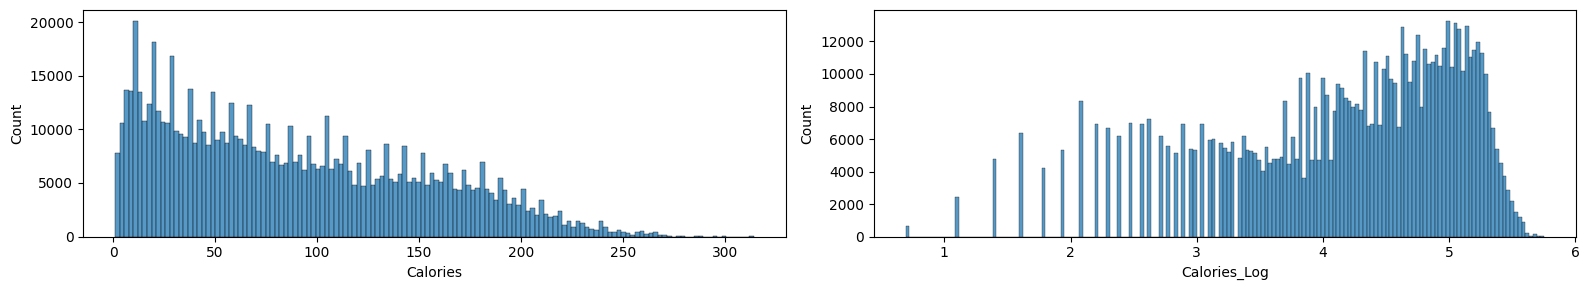

In [79]:
fig, axes = plt.subplots(1, 2, figsize = (16, 3))
sns.histplot(df_train, x = 'Calories', ax = axes[0])
sns.histplot(df_train, x = 'Calories_Log', ax = axes[1])
plt.tight_layout()
plt.show()

- Calories는 좌측으로 치우친 분포를 하고 있습니다.

- Calories_log는 4개 ~ 4개의 봉우리가 있습니다. 봉우리에 관련된 요인을 찾는 것이 도움이 될 수 있으리라 생각됩니다. 

## Calories vs Calories_Log

- LGBMRegressor 심플하게 만들고 Shuffle Split Train size 0.8로 잡아 1회 검증을 통해 결과의 차이를 비교합니다.

In [72]:
X = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp'] 
result = cross_validate(
    lgb.LGBMRegressor(verbose = 0, n_estimators = 700), df_train[X], df_train['Calories'], scoring = 'neg_root_mean_squared_log_error', 
    cv = ShuffleSplit(n_splits = 1, train_size = 0.8, random_state = 1234), params = {'categorical_feature': X_cat},
    return_train_score = True, return_estimator = True
)
result

{'fit_time': array([2.32884884]),
 'score_time': array([0.65864682]),
 'estimator': [LGBMRegressor(n_estimators=700, verbose=0)],
 'test_score': array([-0.06283713]),
 'train_score': array([-0.06006336])}

In [86]:
X = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp'] 
result = cross_validate(
    lgb.LGBMRegressor(verbose = 0, n_estimators = 120), df_train[X], df_train['Calories_Log'], scoring = 'neg_root_mean_squared_error', 
    cv = ShuffleSplit(n_splits = 1, train_size = 0.8, random_state = 1234), params = {'categorical_feature': X_cat},
    return_train_score = True, return_estimator = True
)
result

{'fit_time': array([0.66256213]),
 'score_time': array([0.13081861]),
 'estimator': [LGBMRegressor(n_estimators=120, verbose=0)],
 'test_score': array([-0.06239613]),
 'train_score': array([-0.06081547])}

In [87]:
X = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp'] 
result = cross_validate(
    lgb.LGBMRegressor(verbose = 0, n_estimators = 700), df_train[X], df_train['Calories_Log'], scoring = 'neg_root_mean_squared_error', 
    cv = ShuffleSplit(n_splits = 1, train_size = 0.8, random_state = 1234), params = {'categorical_feature': X_cat},
    return_train_score = True, return_estimator = True
)
result

{'fit_time': array([2.2828002]),
 'score_time': array([0.66662002]),
 'estimator': [LGBMRegressor(n_estimators=700, verbose=0)],
 'test_score': array([-0.06091758]),
 'train_score': array([-0.0560343])}

- 결론: Calories_Log로 모델을 만들 때, 성능이 좋습니다. Calories를 Target으로 했을 경우, n_estimators 가  700보다 크면 과적합이 발생하기 시작한 반면,
Calories_Log로 할 경우에는 n_estimators 가 700 이후에도 test_score 가 떨어지지 않았고 teest의 성능도 Calories를 사용했을 때 보다 때 보다 좋음을 확인할 수 있었습니다.
- Calories_Log 만을 사용하여 모델을 만듭니다.
